In [34]:
import jsonlines
import os
import pandas as pd
import numpy as np

from statistics import mean
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import figure
import seaborn as sb
#pip install numba==0.57.0
import numba as nb
from numba import njit
from numba.core import types
from numba.typed import Dict

# A note on packages...

This analysis uses jsonlines to read history files, pandas & numpy for most data manipulation, matplotlib & seaborn for plotting, and numba to support fast nDCG calculations. It also makes use of the Python built-ins statistics and warnings. It has been tested with the following package versions (though it is not limited to these versions):
* jsonlines 3.1.0
* pandas 1.5.3
* numpy 1.24.3
* matplotlib 3.7.1
* seaborn 0.12.2
* numba 0.57.0

# Functions

In [38]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicitly determined. Defaulting to integer...")
        var = int(var)
    return var

# given an item id return a list of its features as binary values
def get_item_features(item_features, item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [39]:
### VISUALIZATION FUNCTIONS ###

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['COUNTRY_low_pfr'] == 0) & (alloc_df['loan_buck_5'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)

def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc

In [40]:
# generate array for denom of ndcg calcs
rec_list = 10
base_logs = np.log2(np.arange(rec_list)+2)

@njit
def calculate_ndcg(histories: types.DictType(types.unicode_type, types.DictType(types.unicode_type, types.float64[:])),
                  recommender: types.DictType(types.unicode_type, types.UniTuple(types.float64[:], 2)),
                  base_logs: types.float64[:]) -> types.float64[:]:
    avg_of_ndcg = []
    for history in histories:
        i_count = 0
        all_ndcg = 0
        for user, items in histories[history].items():
            scores = np.empty(0)
            for item in items:
                idx_array = np.asarray(recommender[user][1] == item).nonzero()[0]
                if idx_array.size != 0:
                    idx = idx_array[0]
                    score = recommender[user][0][idx]
                else:
                    score = 0.0
                scores = np.append(scores, score)
            ideal_scores = np.sort(recommender[user][0])[::-1][:len(scores)]
            if len(ideal_scores) < len(scores):
                ideal_scores= np.append(ideal_scores, np.zeros(len(scores) - len(ideal_scores)))
            #while len(ideal_scores) < len(scores):
            #    ideal_scores = np.append(ideal_scores, 0.0)
            scores[scores > 0] = 1.0
            ideal_scores[ideal_scores > 0] = 1.0
            recdcg = np.sum(scores/base_logs)
            idealdcg = np.sum(ideal_scores/base_logs)
            if idealdcg == 0.0:
                ndcg = 0.0
            else:
                ndcg = recdcg/idealdcg
            i_count += 1
            all_ndcg += ndcg

        avg_of_ndcg.append(all_ndcg/i_count)
    return avg_of_ndcg

In [262]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["non-en","women_writer_director"]
protected_features = ["non-en","women_writer_director"]
fairness_targets = [0.28, 0.12]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [263]:
prop_fairness_o_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [264]:
ndcg_fairness_k= prop_fairness_o_results.merge(ndcg_table_o, left_index = True, right_index = True)

In [266]:
ndcg_fairness_k['Average Fairness'] = (ndcg_fairness_k['non-en']+ndcg_fairness_k['women_writer_director'])/2

In [267]:
ndcg_fairness_k

,non-en,women_writer_director,NDCG,weight,Average Fairness
history_file_baseline_OFair_movie_3,0.790178,0.272859,0.025353,0.31,0.531518
history_file_baseline_OFair_movie_5,0.238987,0.048953,0.023404,0.51,0.143970
history_file_baseline_OFair_movie_8,0.226034,0.050372,0.024732,0.80,0.138203


In [108]:
ndcg_fairness_k.to_csv('folds_movie.csv')

In [130]:
ndcg_fairness_k['name'] = ndcg_fairness_k.index
ndcg_fairness_k[['history', 'file', 'choice', 'allocation', 'data', 'fold', 'experiment']] = ndcg_fairness_k['name'].str.split('_', expand=True)
ndcg_fairness_k = ndcg_fairness_k.drop(columns=['data',  'name', 'history', 'file'])
ndcg_fairness_k['choice'] = np.where(ndcg_fairness_k['choice'] == 'broda', 'borda', ndcg_fairness_k['choice'])
ndcg_fairness_k['choice'] = np.where(ndcg_fairness_k['choice'] == 'resourse', 'rescore', ndcg_fairness_k['choice'])
ndcg_fairness_k['allocation'] = np.where(ndcg_fairness_k['allocation'] == 'weight', 'weighted', ndcg_fairness_k['allocation'])
ndcg_fairness_k['fairness'] = (ndcg_fairness_k['women_writer_director']+ndcg_fairness_k['non-en'])/2
ndcg_fairness_k['difference'] = ndcg_fairness_k['non-en']-ndcg_fairness_k['women_writer_director']


In [136]:
df = ndcg_fairness_k

In [147]:
# Grouping by 'choice', 'allocation', 'experiment'
grouped_df = df.groupby(['choice', 'allocation', 'experiment']).agg({'NDCG': ['mean', 'std'], 'fairness': ['mean', 'std']})




/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_50287/3381200233.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_fairness_per_choice_allocation = grouped_df.groupby(['choice', 'allocation'])['fairness', 'mean'].mean().reset_index()


TypeError: other must be a MultiIndex or a list of tuples

In [145]:
grouped_df

NDCG            fairness          
                                    mean       std      mean       std
choice   allocation experiment                                        
borda    least      1           0.031745  0.001729  0.769812  0.048914
                    10          0.033929  0.001034  0.422592  0.048004
                    2           0.032717  0.001798  0.765160  0.051742
                    3           0.033239  0.001901  0.724757  0.062614
                    4           0.033573  0.001478  0.629242  0.063860
                    5           0.033736  0.001467  0.560953  0.058011
                    6           0.033877  0.001347  0.515217  0.056571
                    7           0.033832  0.001327  0.483944  0.053034
                    8           0.033873  0.001236  0.459403  0.050178
                    9           0.033968  0.001217  0.439248  0.048777
copeland least      1           0.032465  0.000835  0.766330  0.046064
                    10          0.032465  0.000835  0.766330  0.046064
                    2           0.032465  0.000835  0.766330  0.046064
                    3           0.032465  0.000835  0.766330  0.046064
                    4           0.032465  0.000835  0.766330  0.046064
                    5           0.032465  0.000835  0.766330  0.046064
                    6           0.032465  0.000835  0.766330  0.046064
                    7           0.032465  0.000835  0.766330  0.046064
                    8           0.032465  0.000835  0.766330  0.046064
                    9           0.032465  0.000835  0.766330  0.046064

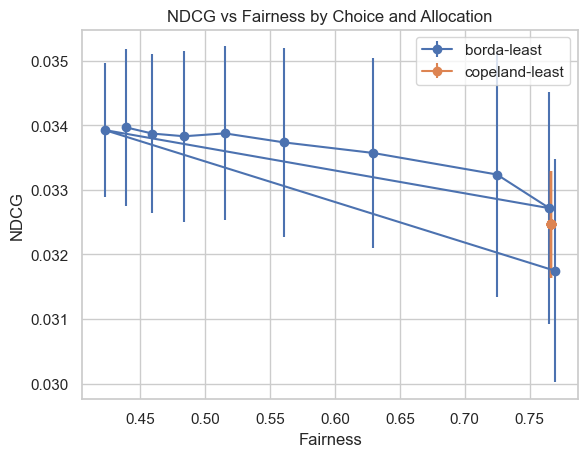

In [152]:
for (choice, allocation), data in grouped_df.groupby(['choice', 'allocation']):
    plt.errorbar(data['fairness']['mean'], data['NDCG']['mean'],
                 yerr=data['NDCG']['std'], fmt='o-', label=f'{choice}-{allocation}')

# Adding labels and title
plt.xlabel('Fairness')
plt.ylabel('NDCG')
plt.title('NDCG vs Fairness by Choice and Allocation')
plt.legend()
plt.show()

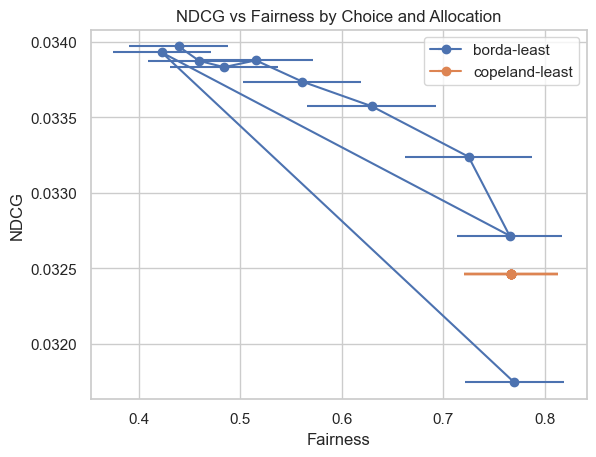

In [153]:
# Separate data for different choice-allocation combinations
for (choice, allocation), data in grouped_df.groupby(['choice', 'allocation']):
    plt.errorbar(data['fairness']['mean'], data['NDCG']['mean'],
                 xerr=data['fairness']['std'], fmt='o-', label=f'{choice}-{allocation}')

# Adding labels and title
plt.xlabel('Fairness')
plt.ylabel('NDCG')
plt.title('NDCG vs Fairness by Choice and Allocation')
plt.legend()
plt.show()

/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_50287/51525452.py:5: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  filtered_df = borda_data.loc[(slice(None), range(1, 11)), :]


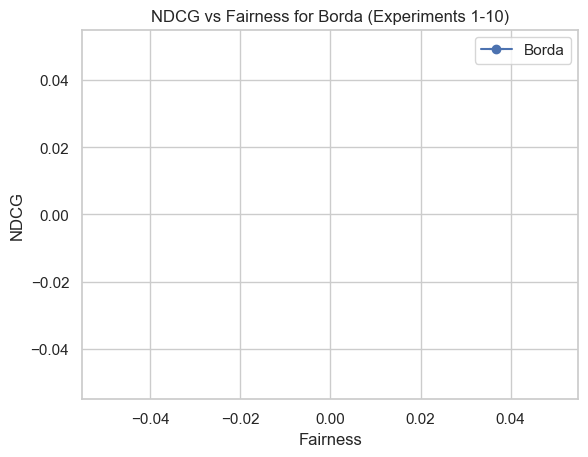

## Movies


In [5]:
# Base paths and experiment numbers
base_path = "../PycharmProjects/scruf_tors_2023/Movies/data/"
experiments = range(1, 11)
folds = range(1,6)

# Specify the base names for each experiment
base_names = [
    #"history_file_borda_least_movie",
    #"history_file_borda_product_movie",
    #"history_file_broda_weighted_movie",
    #"history_file_copeland_least_movie",
    #"history_file_copeland_product_movie",
    #"history_file_copeland_weighted_movie",
    "history_file_rankedPairs_least_movie",
    "history_file_rankedPairs_product_movie",
    "history_file_rankedPairs_weighted_movie",
    #"history_file_resource_least_movie",
    #"history_file_resource_product_movie",
    #"history_file_resource_weight_movie"
    # Add other base names here
]

# Mapping of base names to lists and results dictionaries
#base_name_mapping = {
 #   "history_file_borda_weighted_movie": ('borda_w', 'results_borda_w'),
#}

# Generate file paths and mechanisms dynamically
history_files = []
mechanisms = []

for base_name in base_names:
  for fold in folds:
    for experiment in experiments:
      history_file_path = os.path.join(base_path, f"{base_name}_{fold}_{experiment}.json")
      mechanism_name = f"{base_name}_{fold}_{experiment}"
      history_files.append(history_file_path)
      mechanisms.append(mechanism_name)

recs_file = "../PycharmProjects/scruf_tors_2023/Movies/data/ratings.csv"
items_file = "../PycharmProjects/scruf_tors_2023/Movies/data/items.csv"

In [6]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'women_writer_director') | (item_features['Feature'] == 'non-en')]

In [8]:
len(mechanisms)

150

In [9]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [10]:
len(mechanisms)

150

In [11]:
# generate array for denom of ndcg calcs
rec_list = 10
base_logs = np.log2(np.arange(rec_list)+2)

@njit
def calculate_ndcg(histories: types.DictType(types.unicode_type, types.DictType(types.unicode_type, types.float64[:])),
                  recommender: types.DictType(types.unicode_type, types.UniTuple(types.float64[:], 2)),
                  base_logs: types.float64[:]) -> types.float64[:]:
    avg_of_ndcg = []
    for history in histories:
        i_count = 0
        all_ndcg = 0
        for user, items in histories[history].items():
            scores = np.empty(0)
            for item in items:
                idx_array = np.asarray(recommender[user][1] == item).nonzero()[0]
                if idx_array.size != 0:
                    idx = idx_array[0]
                    score = recommender[user][0][idx]
                else:
                    score = 0.0
                scores = np.append(scores, score)
            ideal_scores = np.sort(recommender[user][0])[::-1][:len(scores)]
            if len(ideal_scores) < len(scores):
                ideal_scores= np.append(ideal_scores, np.zeros(len(scores) - len(ideal_scores)))
            #while len(ideal_scores) < len(scores):
            #    ideal_scores = np.append(ideal_scores, 0.0)
            scores[scores > 0] = 1.0
            ideal_scores[ideal_scores > 0] = 1.0
            recdcg = np.sum(scores/base_logs)
            idealdcg = np.sum(ideal_scores/base_logs)
            if idealdcg == 0.0:
                ndcg = 0.0
            else:
                ndcg = recdcg/idealdcg
            i_count += 1
            all_ndcg += ndcg

        avg_of_ndcg.append(all_ndcg/i_count)
    return avg_of_ndcg

In [12]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type, #int64
    value_type=types.UniTuple(types.float64[:], 2)
)
for user in recommender["User"].unique():
    scores = np.asarray(recommender[recommender["User"] == user]["Score"], dtype='f8')
    items = np.asarray(recommender[recommender["User"] == user]["Item"], dtype='f8')
    light_recommender[str(user)] = (scores, items)

In [13]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [14]:
avg_of_ndcg

[0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.03142258352766423,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030058524359491384,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.030664154943303906,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.03161263561297531,
 0.032514726467215316,
 0.032514726467215316,
 0.032514726467215316,
 0.032514726467215316,
 0.03251

In [15]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

,NDCG
history_file_rankedPairs_least_movie_1_1,0.031423
history_file_rankedPairs_least_movie_1_2,0.031423
history_file_rankedPairs_least_movie_1_3,0.031423
history_file_rankedPairs_least_movie_1_4,0.031423
history_file_rankedPairs_least_movie_1_5,0.031423
...,...
history_file_rankedPairs_weighted_movie_5_6,0.034358
history_file_rankedPairs_weighted_movie_5_7,0.034383
history_file_rankedPairs_weighted_movie_5_8,0.034663
history_file_rankedPairs_weighted_movie_5_9,0.034732


In [16]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["non-en","women_writer_director"]
protected_features = ["non-en","women_writer_director"]
fairness_targets = [0.28, 0.12]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [17]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [18]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [44]:
ndcg_fairness

,non-en,women_writer_director,NDCG
history_file_borda_least_movie_3,1.226253,0.347636,0.030725
history_file_borda_product_movie_3,1.114665,0.357143,0.032898
history_file_broda_weighted_movie_3,0.900002,0.376156,0.033412
history_file_copeland_least_movie_3,1.204301,0.396305,0.031423
history_file_copeland_product_movie_3,1.189037,0.392616,0.031958
history_file_copeland_weighted_movie_3,1.059023,0.402548,0.032245
history_file_rankedPairs_least_movie_3,1.204301,0.396305,0.031423
history_file_rankedPairs_product_movie_3,1.243949,0.359129,0.029829
history_file_rankedPairs_weighted_movie_3,1.090402,0.403258,0.032426
history_file_resource_least_movie_3,1.052516,0.325927,0.033111


In [21]:
ndcg_fairness['name'] = ndcg_fairness.index


In [23]:
ndcg_fairness

,non-en,women_writer_director,NDCG,name
history_file_rankedPairs_least_movie_1_1,1.204301,0.396305,0.031423,history_file_rankedPairs_least_movie_1_1
history_file_rankedPairs_least_movie_1_2,1.204301,0.396305,0.031423,history_file_rankedPairs_least_movie_1_2
history_file_rankedPairs_least_movie_1_3,1.204301,0.396305,0.031423,history_file_rankedPairs_least_movie_1_3
history_file_rankedPairs_least_movie_1_4,1.204301,0.396305,0.031423,history_file_rankedPairs_least_movie_1_4
history_file_rankedPairs_least_movie_1_5,1.204301,0.396305,0.031423,history_file_rankedPairs_least_movie_1_5
...,...,...,...,...
history_file_rankedPairs_weighted_movie_5_6,0.960144,0.342812,0.034358,history_file_rankedPairs_weighted_movie_5_6
history_file_rankedPairs_weighted_movie_5_7,0.852023,0.299818,0.034383,history_file_rankedPairs_weighted_movie_5_7
history_file_rankedPairs_weighted_movie_5_8,0.753691,0.255548,0.034663,history_file_rankedPairs_weighted_movie_5_8
history_file_rankedPairs_weighted_movie_5_9,0.647515,0.198791,0.034732,history_file_rankedPairs_weighted_movie_5_9


In [27]:
ndcg_fairness[['history', 'file', 'choice', 'allocation', 'data', 'fold', 'experiment']] = ndcg_fairness['name'].str.split('_', expand=True)


In [29]:
ndcg_fairness = ndcg_fairness.drop(columns=['data', 'name', 'history', 'file'])

In [30]:
ndcg_fairness['choice'] = np.where(ndcg_fairness['choice'] == 'broda', 'borda', ndcg_fairness['choice'])
ndcg_fairness['choice'] = np.where(ndcg_fairness['choice'] == 'resourse', 'rescore', ndcg_fairness['choice'])
ndcg_fairness['allocation'] = np.where(ndcg_fairness['allocation'] == 'weight', 'weighted', ndcg_fairness['allocation'])

In [31]:
ndcg_fairness['Average Fairness Score'] = (ndcg_fairness['women_writer_director']+ndcg_fairness['non-en'])/2
ndcg_fairness['Difference'] = ndcg_fairness['non-en']-ndcg_fairness['women_writer_director']

In [194]:
ndcg_fairness = pd.read_csv('movies_3.csv')

In [19]:
ndcg_fairness.to_csv('movies_rp.csv')

In [32]:
ndcg_fairness

,non-en,women_writer_director,NDCG,choice,allocation,fold,experiment,Average Fairness Score,Difference
history_file_rankedPairs_least_movie_1_1,1.204301,0.396305,0.031423,rankedPairs,least,1,1,0.800303,0.807995
history_file_rankedPairs_least_movie_1_2,1.204301,0.396305,0.031423,rankedPairs,least,1,2,0.800303,0.807995
history_file_rankedPairs_least_movie_1_3,1.204301,0.396305,0.031423,rankedPairs,least,1,3,0.800303,0.807995
history_file_rankedPairs_least_movie_1_4,1.204301,0.396305,0.031423,rankedPairs,least,1,4,0.800303,0.807995
history_file_rankedPairs_least_movie_1_5,1.204301,0.396305,0.031423,rankedPairs,least,1,5,0.800303,0.807995
...,...,...,...,...,...,...,...,...,...
history_file_rankedPairs_weighted_movie_5_6,0.960144,0.342812,0.034358,rankedPairs,weighted,5,6,0.651478,0.617333
history_file_rankedPairs_weighted_movie_5_7,0.852023,0.299818,0.034383,rankedPairs,weighted,5,7,0.575920,0.552204
history_file_rankedPairs_weighted_movie_5_8,0.753691,0.255548,0.034663,rankedPairs,weighted,5,8,0.504620,0.498143
history_file_rankedPairs_weighted_movie_5_9,0.647515,0.198791,0.034732,rankedPairs,weighted,5,9,0.423153,0.448724


In [44]:
df

,choice,allocation,experiment,NDCG_mean,NDCG_std,fairness_mean,fairness_std
0,borda,least,1,0.030924,0.001135,0.789939,0.014701
1,borda,least,10,0.033617,0.000855,0.435388,0.034102
2,borda,least,2,0.031905,0.001265,0.787721,0.014187
3,borda,least,3,0.032393,0.001245,0.749653,0.029926
4,borda,least,4,0.032975,0.001148,0.652844,0.037192
...,...,...,...,...,...,...,...
85,copeland,least,5,0.030924,0.001135,0.789939,0.014701
86,copeland,least,6,0.030924,0.001135,0.789939,0.014701
87,copeland,least,7,0.030924,0.001135,0.789939,0.014701
88,copeland,least,8,0.030924,0.001135,0.789939,0.014701


In [34]:
df = ndcg_fairness
grouped_df = df.groupby(['choice', 'allocation', 'experiment']).agg({'NDCG': ['mean', 'std'], 'Average Fairness Score': ['mean', 'std']})

In [40]:
df = pd.read_csv('grouped_df.csv')

In [45]:
reset_df = grouped_df.reset_index()

# Rename the columns to the desired format
reset_df.columns = ['choice', 'allocation', 'experiment', 'NDCG_mean', 'NDCG_std', 'fairness_mean', 'fairness_std']


In [47]:
full_movies = reset_df.append(df)

/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_48575/1076107279.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_movies = reset_df.append(df)


In [49]:
full_movies['experiment'] = full_movies['experiment'].astype('int')

In [53]:
full_movies = full_movies.sort_values(by=['choice', 'allocation', 'experiment'])
full_movies

,choice,allocation,experiment,NDCG_mean,NDCG_std,fairness_mean,fairness_std
10,Ranked Pairs,Lottery,1,0.033020,0.002024,0.747643,0.045347
12,Ranked Pairs,Lottery,2,0.033020,0.002024,0.747643,0.045347
13,Ranked Pairs,Lottery,3,0.033020,0.002024,0.747643,0.045347
14,Ranked Pairs,Lottery,4,0.033020,0.002024,0.747643,0.045347
15,Ranked Pairs,Lottery,5,0.033020,0.002024,0.747643,0.045347
...,...,...,...,...,...,...,...
46,copeland,weighted,6,0.032911,0.001489,0.638608,0.087987
47,copeland,weighted,7,0.032933,0.001452,0.619475,0.090089
48,copeland,weighted,8,0.033110,0.001397,0.600861,0.089964
49,copeland,weighted,9,0.033188,0.001217,0.582707,0.086077


In [59]:
# Create a dataset where 'experiment' is 3
experiment_3_dataset = full_movies[full_movies['experiment'] == 3]

# Create four datasets for each 'choice' option
choice_datasets = {}
for choice_option in full_movies['choice'].unique():
    choice_datasets[choice_option] = full_movies[full_movies['choice'] == choice_option]

In [50]:
full_movies.to_csv('full_movies_avg.csv')

In [51]:
full_movies['allocation'] = np.where(full_movies['allocation'] == 'product', 'Lottery', full_movies['allocation'])
full_movies['choice'] = np.where(full_movies['choice'] == 'resource', 'Weighted Rescore', full_movies['choice'])
full_movies['choice'] = np.where(full_movies['choice'] == 'rankedPairs', 'Ranked Pairs', full_movies['choice'])

In [52]:
full_movies

,choice,allocation,experiment,NDCG_mean,NDCG_std,fairness_mean,fairness_std
0,Ranked Pairs,least,1,0.031255,0.000939,0.788051,0.011853
1,Ranked Pairs,least,10,0.031255,0.000939,0.788051,0.011853
2,Ranked Pairs,least,2,0.031255,0.000939,0.788051,0.011853
3,Ranked Pairs,least,3,0.031255,0.000939,0.788051,0.011853
4,Ranked Pairs,least,4,0.031255,0.000939,0.788051,0.011853
...,...,...,...,...,...,...,...
85,copeland,least,5,0.030924,0.001135,0.789939,0.014701
86,copeland,least,6,0.030924,0.001135,0.789939,0.014701
87,copeland,least,7,0.030924,0.001135,0.789939,0.014701
88,copeland,least,8,0.030924,0.001135,0.789939,0.014701


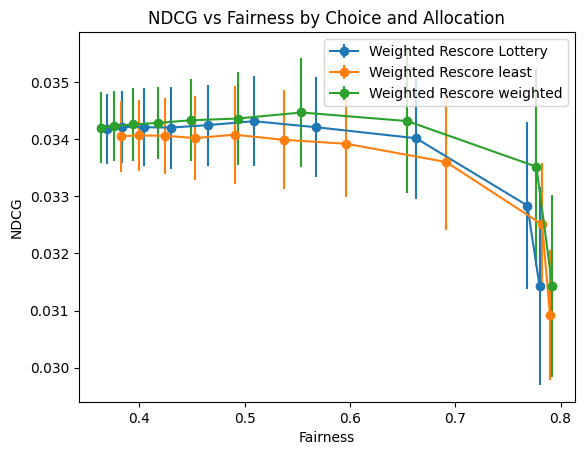

In [64]:
for (choice, allocation), data in choice_datasets['Weighted Rescore'].groupby(['choice', 'allocation']):
    plt.errorbar(data['fairness_mean'], data['NDCG_mean'],
                 yerr=data['NDCG_std'], fmt='o-', label=f'{choice} {allocation}')

# Adding labels and title
plt.xlabel('Fairness')
plt.ylabel('NDCG')
plt.title('NDCG vs Fairness by Choice and Allocation')
plt.legend()
plt.show()

In [56]:
choice_datasets

{'borda':    choice allocation  experiment  NDCG_mean  NDCG_std  fairness_mean  \
 0   borda      least           1   0.030924  0.001135       0.789939   
 1   borda      least          10   0.033617  0.000855       0.435388   
 2   borda      least           2   0.031905  0.001265       0.787721   
 3   borda      least           3   0.032393  0.001245       0.749653   
 4   borda      least           4   0.032975  0.001148       0.652844   
 5   borda      least           5   0.033260  0.001221       0.581290   
 6   borda      least           6   0.033463  0.001148       0.533785   
 7   borda      least           7   0.033394  0.001094       0.500819   
 8   borda      least           8   0.033468  0.001020       0.474392   
 9   borda      least           9   0.033584  0.001020       0.452456   
 10  borda    product           1   0.031430  0.001731       0.780083   
 11  borda    product          10   0.033887  0.000916       0.420032   
 12  borda    product           2   0.0323

In [50]:
def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["0","1"],var_name='Agent', value_name="Fairness")

TypeError: cannot unpack non-iterable NoneType object

In [71]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='fairness_mean',
                      y='NDCG_mean',
                      data=fairness_df,
                      style="allocation",
                      hue="choice",
                      s=100,
                      markers={"Lottery": "^", "weighted": "X", "least": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [202]:
def difference_scatterplot(fairness_df, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Difference',
                      y='NDCG',
                      data=fairness_df,
                      style="allocation",
                      hue="choice",
                      s=100,
                      markers={"product": "^", "weighted": "X", "least": "o"})

    sb.set(font_scale = 1.25)
    plt.xlabel("Fairness Difference Between Agents", fontsize=12, labelpad=10)
    plt.ylabel('nDCG', fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [75]:
baseline_accuracy = 0.0345

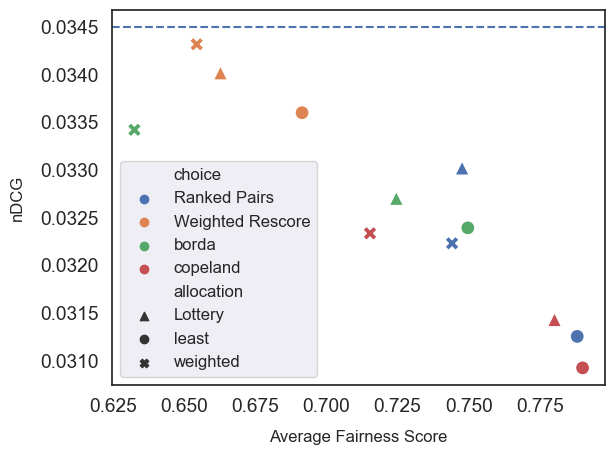

In [76]:
make_scatterplot(experiment_3_dataset, baseline_accuracy, filename='synthetic_scatter.png')

In [77]:
experiment_3_dataset.to_latex(index=False)

/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_48575/2223253740.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  experiment_3_dataset.to_latex(index=False)


'\\begin{tabular}{llrrrrr}\n\\toprule\n          choice & allocation &  experiment &  NDCG\\_mean &  NDCG\\_std &  fairness\\_mean &  fairness\\_std \\\\\n\\midrule\n    Ranked Pairs &    Lottery &           3 &   0.033020 &  0.002024 &       0.747643 &      0.045347 \\\\\n    Ranked Pairs &      least &           3 &   0.031255 &  0.000939 &       0.788051 &      0.011853 \\\\\n    Ranked Pairs &   weighted &           3 &   0.032231 &  0.001780 &       0.744120 &      0.031019 \\\\\nWeighted Rescore &    Lottery &           3 &   0.034018 &  0.001064 &       0.662827 &      0.029949 \\\\\nWeighted Rescore &      least &           3 &   0.033601 &  0.001185 &       0.691467 &      0.031123 \\\\\nWeighted Rescore &   weighted &           3 &   0.034319 &  0.001263 &       0.654484 &      0.032695 \\\\\n           borda &    Lottery &           3 &   0.032701 &  0.001383 &       0.724569 &      0.033498 \\\\\n           borda &      least &           3 &   0.032393 &  0.001245 &       0

In [193]:
ndcg_fairness

,Unnamed: 0,non-en,women_writer_director,NDCG,choice,allocation,Average Fairness Score,Difference,history,file,Experiment
0,history_file_borda_least_movie_3,1.226253,0.347636,0.030725,NaN,NaN,0.786945,0.878617,NaN,NaN,NaN
1,history_file_borda_product_movie_3,1.114665,0.357143,0.032898,NaN,NaN,0.735904,0.757522,NaN,NaN,NaN
2,history_file_broda_weighted_movie_3,0.900002,0.376156,0.033412,NaN,NaN,0.638079,0.523846,NaN,NaN,NaN
3,history_file_copeland_least_movie_3,1.204301,0.396305,0.031423,NaN,NaN,0.800303,0.807995,NaN,NaN,NaN
4,history_file_copeland_product_movie_3,1.189037,0.392616,0.031958,NaN,NaN,0.790826,0.796421,NaN,NaN,NaN
5,history_file_copeland_weighted_movie_3,1.059023,0.402548,0.032245,NaN,NaN,0.730786,0.656475,NaN,NaN,NaN
6,history_file_rankedPairs_least_movie_3,1.204301,0.396305,0.031423,NaN,NaN,0.800303,0.807995,NaN,NaN,NaN
7,history_file_rankedPairs_product_movie_3,1.243949,0.359129,0.029829,NaN,NaN,0.801539,0.884820,NaN,NaN,NaN
8,history_file_rankedPairs_weighted_movie_3,1.090402,0.403258,0.032426,NaN,NaN,0.746830,0.687144,NaN,NaN,NaN
9,history_file_resource_least_movie_3,1.052516,0.325927,0.033111,NaN,NaN,0.689221,0.726590,NaN,NaN,NaN


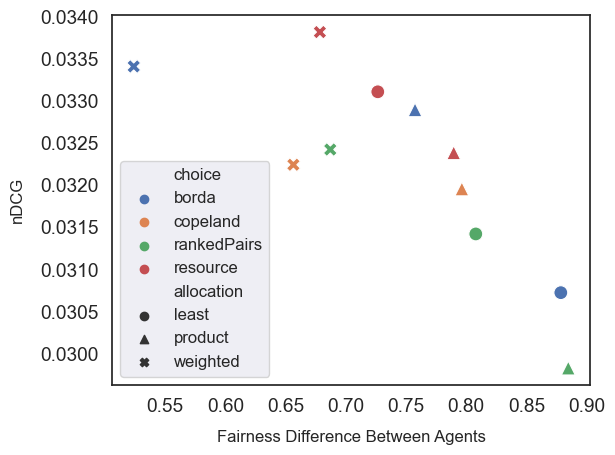

In [203]:
difference_scatterplot(ndcg_fairness, filename='synthetic_scatter.png')

In [ ]:
boxplots = experiments
boxplots.loc[boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
boxplots.loc[boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"

In [ ]:
# generate FacetGrid boxplots of internal representations of fairness scores 
sb.set(font_scale=1.5)

g = sb.catplot(data=boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["0","1"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

# Synthetic Experiments
Below is the code used to analyze experiments using our synthetically-generated dataset. It calculates per-experiment nDCG and adjusted proportional fairness, we use these metrics to create our scatterplots. It also tracks SCRUF's internal representations of fairness which we utilize to create boxplots of the system's fairness scores.

In [ ]:
# specify paths to json outputs from scruf
BORDA_BASE = "/data/history_file_baseline_s1.json"
BORDA_LOT = "/data/history_file_product_alloc_borda_s1.json"
BORDA_WEIGHT = "/data/history_file_weighted_alloc_borda_s1.json"
BORDA_LEAST = "/data/history_file_least_fair_borda_s1.json"

COPELAND_BASE = "/data/history_file_baseline_s1.json"
COPELAND_LOT = "/data/history_file_product_alloc_copeland_s1.json"
COPELAND_WEIGHT = "/data/history_file_weighted_alloc_copeland_s1.json"
COPELAND_LEAST = "/data/history_file_least_fair_copeland_s1.json"

RP_BASE = "/data/history_file_baseline_s1.json"
RP_LOT = "/data/history_file_product_alloc_rankedpairs_s1.json"
RP_WEIGHT = "/data/history_file_weighted_alloc_ranked_pairs_s1.json"
RP_LEAST = "/data/history_file_least_fair_rankedpairs_s1.json"

WR_BASE = "/data/history_file_baseline_s1.json"
WR_LEAST = "/data/history_file_least_fair_rescore_s1.json"
WR_LOT = "/data/history_file_product_alloc_rescore_s1.json"
WR_WEIGHT = "/data/history_file_weighted_alloc_weighted_s1.json"

# paths to user|item|score files and item|feature files
recs_file = "/data/recs_s1.csv"
items_file = "/data/items_s1.csv"

In [ ]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])

In [ ]:
# no need to change unless changing allocation/choice mechanism
history_files = [BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_LEAST,RP_LOT,RP_WEIGHT,WEIGHT_LEAST, WEIGHT_LOT,WEIGHT_WEIGHT,BASELINE]


mechanisms = ['Borda Lottery', 'Borda Weighted Product',
                  'Borda Least Fair','Copeland Least Fair',
                  'Copeland Lottery', 'Copeland Weighted Product',
                  'Ranked Pairs Least Fair',
                  'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product','Weighted Rescore Least Fair','Weighted Rescore Lottery',
                  'Weighted Rescore Weighted Product', 'Baseline']

In [ ]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [ ]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 2),
)
for user in recommender["User"].unique():
    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    light_recommender[user] = (scores, items)

In [ ]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [ ]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

In [ ]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["0","1","2","3","4","5","6","7","8","9"]
protected_features = ["0", "1"]
fairness_targets = [0.25, 0.25]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [ ]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [ ]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [ ]:
# get fairness data to create boxplots
# create df w/ allocation/choice mechs and fairness scores over time
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["0","1"],var_name='Agent', value_name="Fairness")

In [ ]:
# store baseline means, then remove baseline
baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "0"]["Fairness"].mean()
baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "1"]["Fairness"].mean()
boxplots = experiments[experiments["Allocation Mech"] != "Baseline"]

In [ ]:
# rename for readability
boxplots.loc[boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
boxplots.loc[boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"

In [ ]:
# generate FacetGrid boxplots of internal representations of fairness scores 
sb.set(font_scale=1.5)

g = sb.catplot(data=boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["0","1"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

In [ ]:
ndcg_fairness

In [ ]:
baseline_accuracy = ndcg_fairness.loc["Baseline"]
ndcg_fairness = ndcg_fairness.drop("Baseline")

In [ ]:
# rename for readability
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted')

In [ ]:
ndcg_fairness["Average Fairness Score"] = ndcg_fairness.apply(lambda x: (x["COUNTRY_low_pfr"]+x["loan_buck_5"])/2, axis=1)

In [ ]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='synthetic_scatter.png')

# Kiva Experiments
Below is the code used to analyze experiments using the Kiva dataset. It mirrors the above analysis, with a few small changes to support the Kiva dataset.

In [111]:
# Base paths and experiment numbers
base_path = "../PycharmProjects/scruf_tors_2023/kiva/data/"
experiments = range(1, 2)
folds = range(1,2)

# Specify the base names for each experiment
base_names = [
    "history_file_baseline_movie"

]

# Mapping of base names to lists and results dictionaries
#base_name_mapping = {
 #   "history_file_borda_weighted_movie": ('borda_w', 'results_borda_w'),
#}

# Generate file paths and mechanisms dynamically
history_files = []
mechanisms = []

for base_name in base_names:
    for fold in folds:
        for experiment_number in experiments:
            history_file_path = os.path.join(base_path, f"{base_name}.json")            
            mechanism_name = f"history_file_baseline_kiva Experiment 1 Fold 1"
            history_files.append(history_file_path)
            mechanisms.append(mechanism_name)

# paths to user|item|score files and item|feature files
recs_file = "../PycharmProjects/scruf_tors_2023/kiva/data/ratings.csv"
items_file = "../PycharmProjects/scruf_tors_2023/kiva/data/items.csv"

# Base paths and experiment numbers
base_path = "../PycharmProjects/scruf_tors_2023/kiva/data/"
experiments = range(1, 11)
#folds = range(1,6)

# Specify the base names for each experiment
base_names = [
    "history_file_baseline_OFair_kiva_5",
    "history_file_baseline_OFair_kiva_2",
    "history_file_baseline_OFair_kiva"

]

# Mapping of base names to lists and results dictionaries
#base_name_mapping = {
 #   "history_file_borda_weighted_movie": ('borda_w', 'results_borda_w'),
#}

# Generate file paths and mechanisms dynamically
history_files = []
mechanisms = []

#for base_name in base_names:
   # for fold in folds:
for base_name in base_names:
    history_file_path = os.path.join(base_path, f"{base_name}.json")            
    mechanism_name = f"{base_name}"
    history_files.append(history_file_path)
    mechanisms.append(mechanism_name)

# paths to user|item|score files and item|feature files
recs_file = "../PycharmProjects/scruf_tors_2023/kiva/data/ratings.csv"
items_file = "../PycharmProjects/scruf_tors_2023/kiva/data/items.csv"

In [112]:
history_files

['../PycharmProjects/scruf_tors_2023/kiva/data/history_file_baseline_movie.json']

In [113]:
recommender = pd.read_csv(recs_file, header=None)
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'COUNTRY_low_pfr') | (item_features['Feature'] == 'loan_buck_5')]

In [114]:
recommender = recommender.rename(columns = {0: "User", 1: "Item", 2: "Score"})
recommender

,User,Item,Score
0,00043ad3146f033d4bf1beb502fa6e09,41,3.0
1,00043ad3146f033d4bf1beb502fa6e09,60,3.0
2,00043ad3146f033d4bf1beb502fa6e09,175,3.0
3,00043ad3146f033d4bf1beb502fa6e09,191,3.0
4,00043ad3146f033d4bf1beb502fa6e09,265,3.0
...,...,...,...
110366,fff15c0cb55b7bb93d4822411d03bc9c,1626,3.0
110367,fff15c0cb55b7bb93d4822411d03bc9c,2079,3.0
110368,fff15c0cb55b7bb93d4822411d03bc9c,3359,3.0
110369,fff15c0cb55b7bb93d4822411d03bc9c,4590,3.0


In [115]:
all_features = ["COUNTRY_low_pfr", "loan_buck_5"]

# Create a DataFrame with all possible combinations of Item and Feature
all_combinations = pd.DataFrame([(item_id, feature, 0) for item_id in range(1, 4998) for feature in all_features], columns=["Item", "Feature", "BV"])

# Merge the existing DataFrame with the DataFrame containing all combinations
item_features = pd.merge(item_features, all_combinations, on=["Item", "Feature"], how="right").fillna(0)

item_features['BV'] = item_features['BV_x']+item_features['BV_y']
item_features = item_features.drop(columns=['BV_x', 'BV_y'])

In [116]:
item_features

,Item,Feature,BV
0,1,COUNTRY_low_pfr,0.0
1,1,loan_buck_5,0.0
2,2,COUNTRY_low_pfr,1.0
3,2,loan_buck_5,1.0
4,3,COUNTRY_low_pfr,0.0
...,...,...,...
9989,4995,loan_buck_5,0.0
9990,4996,COUNTRY_low_pfr,0.0
9991,4996,loan_buck_5,0.0
9992,4997,COUNTRY_low_pfr,0.0


New Dataframe with combined features to test intersectionality

In [ ]:
item_features = pd.read_csv('data/kiva_items.csv', names=["Item","Feature","BV"])

In [ ]:
def append_protected_feature_row(item_features, item, features):
    item_rows = item_features[item_features['Item'] == item]
    combined_feature = ' & '.join(features)
    if all(feature in item_rows['Feature'].values for feature in features) and \
       not any(item_rows['Feature'] == combined_feature):
        bv_value = 1
        item_features = item_features.append({'Item': item, 'Feature': combined_feature, 'BV': bv_value}, ignore_index=True)

    return item_features

for item in item_features['Item'].unique():
    item_features = append_protected_feature_row(item_features, item, protected_features)
    
item_features = item_features.drop_duplicates()
item_features = item_features.dropna(subset=['BV'])


# Display rows for a specific item, example: item 2
specific_item_rows = item_features[item_features['Item'] == 2]
print(specific_item_rows)

In [117]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [118]:
history_files

['../PycharmProjects/scruf_tors_2023/kiva/data/history_file_baseline_movie.json']

In [119]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 2),
)
for user in recommender["User"].unique():
    print(recommender[recommender["User"] == user]["Score"])
    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    light_recommender[user] = (scores, items)

0     3.0
1     3.0
2     3.0
3     3.0
4     3.0
5     3.0
6     3.0
7     3.0
8     3.0
9     3.0
10    3.0
11    3.0
12    3.0
13    3.0
14    3.0
15    3.0
16    3.0
17    3.0
18    3.0
19    3.0
20    3.0
21    3.0
22    5.0
23    3.0
24    3.0
25    3.0
26    3.0
27    3.0
28    5.0
29    5.0
30    5.0
31    3.0
32    3.0
33    3.0
34    3.0
35    3.0
36    3.0
37    3.0
38    3.0
39    3.0
40    3.0
41    3.0
42    3.0
43    3.0
44    3.0
45    3.0
46    3.0
47    3.0
Name: Score, dtype: float64
48     3.0
49     3.0
50     3.0
51     3.0
52     3.0
53     5.0
54     3.0
55     3.0
56     3.0
57     3.0
58     4.0
59     4.0
60     3.0
61     3.0
62     3.0
63     3.0
64     3.0
65     3.0
66     3.0
67     3.0
68     4.0
69     3.0
70     3.0
71     5.0
72     3.0
73     3.0
74     3.0
75     4.0
76     3.0
77     3.0
78     3.0
79     3.0
80     3.0
81     3.0
82     3.0
83     3.0
84     3.0
85     4.0
86     4.0
87     3.0
88     3.0
89     3.0
90     3.0
91     3.0
92     3

In [120]:
recommender

,User,Item,Score
0,00043ad3146f033d4bf1beb502fa6e09,41,3.0
1,00043ad3146f033d4bf1beb502fa6e09,60,3.0
2,00043ad3146f033d4bf1beb502fa6e09,175,3.0
3,00043ad3146f033d4bf1beb502fa6e09,191,3.0
4,00043ad3146f033d4bf1beb502fa6e09,265,3.0
...,...,...,...
110366,fff15c0cb55b7bb93d4822411d03bc9c,1626,3.0
110367,fff15c0cb55b7bb93d4822411d03bc9c,2079,3.0
110368,fff15c0cb55b7bb93d4822411d03bc9c,3359,3.0
110369,fff15c0cb55b7bb93d4822411d03bc9c,4590,3.0


In [121]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [122]:
# creates dataframe of average NDCG values
ndcg_table_k_f = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table_k_f

,NDCG
history_file_baseline_kiva Experiment 1 Fold 1,0.007424


In [123]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["COUNTRY_low_pfr", "loan_buck_5"]
protected_features = ["COUNTRY_low_pfr", "loan_buck_5"]
fairness_targets = [0.3, 0.20]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [124]:
prop_fairness_results_k_f = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [125]:
prop_fairness_results_k_f

,COUNTRY_low_pfr,loan_buck_5
history_file_baseline_kiva Experiment 1 Fold 1,0.656429,0.0397


In [126]:
ndcg_fairness_k = prop_fairness_results_k_f.merge(ndcg_table_k_f, left_index = True, right_index = True)

In [127]:
frames = [ndcg_fairness_k, ndcg_fairness_k_f]

result = pd.concat(frames)

In [128]:
result

,COUNTRY_low_pfr,loan_buck_5,NDCG
history_file_baseline_kiva Experiment 1 Fold 1,0.656429,0.039700,0.007424
history_file_ofair_kiva Experiment 1 Fold 1,0.662256,0.000749,0.006263
history_file_ofair_kiva Experiment 2 Fold 1,0.661590,0.453933,0.007985
history_file_ofair_kiva Experiment 3 Fold 1,0.334665,0.994507,0.003952
history_file_ofair_kiva Experiment 4 Fold 1,0.323845,0.334956,0.008107
history_file_ofair_kiva Experiment 5 Fold 1,0.331086,0.492884,0.007288


In [130]:
result.to_csv('ofair_kiva.csv')

In [288]:
ndcg_fairness_k_f['name'] = ndcg_fairness_k_f.index
ndcg_fairness_k_f[['history', 'file', 'choice', 'allocation', 'Experiment']] = ndcg_fairness_k_f['name'].str.split('_', expand=True)

In [63]:
ndcg_fairness_k_f

,COUNTRY_low_pfr,loan_buck_5,NDCG
history_file_ofair_kiva Experiment 1 Fold 1,0.662256,0.000749,0.006263
history_file_ofair_kiva Experiment 2 Fold 1,0.661590,0.453933,0.007985
history_file_ofair_kiva Experiment 3 Fold 1,0.334665,0.994507,0.003952
history_file_ofair_kiva Experiment 4 Fold 1,0.323845,0.334956,0.008107
history_file_ofair_kiva Experiment 5 Fold 1,0.331086,0.492884,0.007288


In [323]:
ndcg_fairness_k_f.to_csv('kiva_results.csv')

In [291]:
ndcg_fairness_k_f[['data', 'f', 'Fold', 'e', 'Experiment']] = ndcg_fairness_k_f['Experiment'].str.split(' ', expand=True)

In [294]:
ndcg_fairness_k_f['fold']=ndcg_fairness_k_f['Experiment']
ndcg_fairness_k_f['experiment']=ndcg_fairness_k_f['Fold']

In [296]:

#ndcg_fairness_k[['history', 'file', 'choice', 'allocation', 'data', 'fold', 'experiment']] = ndcg_fairness_k['name'].str.split('_', expand=True)
ndcg_fairness_k_f = ndcg_fairness_k_f.drop(columns=[ 'name', 'history', 'file', 'Experiment', 'Fold'])
ndcg_fairness_k_f['COUNTRY_low_pfr'] = (ndcg_fairness_k_f['COUNTRY_low_pfr']*.8)/.08
ndcg_fairness_k_f['choice'] = np.where(ndcg_fairness_k_f['choice'] == 'broda', 'borda', ndcg_fairness_k_f['choice'])
ndcg_fairness_k_f['choice'] = np.where(ndcg_fairness_k_f['choice'] == 'resourse', 'rescore', ndcg_fairness_k_f['choice'])
ndcg_fairness_k_f['allocation'] = np.where(ndcg_fairness_k_f['allocation'] == 'weight', 'weighted', ndcg_fairness_k_f['allocation'])
ndcg_fairness_k_f['fairness average'] = (ndcg_fairness_k_f['COUNTRY_low_pfr']+ndcg_fairness_k_f['loan_buck_5'])/2
ndcg_fairness_k_f['fairness norm'] = (ndcg_fairness_k_f['COUNTRY_low_pfr']**(1/2)+ndcg_fairness_k_f['loan_buck_5']**(1/2))/2
ndcg_fairness_k_f['difference'] = ndcg_fairness_k_f['COUNTRY_low_pfr']-ndcg_fairness_k_f['loan_buck_5']

In [313]:
ndcg_fairness_k_f

,COUNTRY_low_pfr,loan_buck_5,NDCG,choice,allocation,data,f,e,fold,experiment,fairness average,fairness norm,difference
history_file_borda_least_kiva Experiment 1 Fold 1,3.722846,0.000749,0.008016,borda,least,kiva,Experiment,Fold,1,1,1.861798,0.978418,3.722097
history_file_borda_least_kiva Experiment 2 Fold 1,3.722846,0.000749,0.008016,borda,least,kiva,Experiment,Fold,1,2,1.861798,0.978418,3.722097
history_file_borda_least_kiva Experiment 3 Fold 1,3.722846,0.000749,0.008016,borda,least,kiva,Experiment,Fold,1,3,1.861798,0.978418,3.722097
history_file_borda_least_kiva Experiment 4 Fold 1,3.722846,0.000749,0.008016,borda,least,kiva,Experiment,Fold,1,4,1.861798,0.978418,3.722097
history_file_borda_least_kiva Experiment 5 Fold 1,3.722846,0.000749,0.008016,borda,least,kiva,Experiment,Fold,1,5,1.861798,0.978418,3.722097
...,...,...,...,...,...,...,...,...,...,...,...,...,...
history_file_resource_weight_kiva Experiment 6 Fold 5,4.380462,0.148814,0.010101,resource,weighted,kiva,Experiment,Fold,5,6,2.264638,1.239360,4.231648
history_file_resource_weight_kiva Experiment 7 Fold 5,4.380462,0.148814,0.010101,resource,weighted,kiva,Experiment,Fold,5,7,2.264638,1.239360,4.231648
history_file_resource_weight_kiva Experiment 8 Fold 5,4.380462,0.148814,0.010101,resource,weighted,kiva,Experiment,Fold,5,8,2.264638,1.239360,4.231648
history_file_resource_weight_kiva Experiment 9 Fold 5,4.380462,0.148814,0.010113,resource,weighted,kiva,Experiment,Fold,5,9,2.264638,1.239360,4.231648


In [318]:
ndcg_fairness_k_f['experiment'] = ndcg_fairness_k_f['experiment'].astype('int')

In [319]:
# Grouping by 'choice', 'allocation', 'experiment'
grouped_df = ndcg_fairness_k_f.groupby(['choice', 'allocation', 'experiment']).agg({'NDCG': ['mean', 'std'], 'fairness norm': ['mean', 'std']})

In [320]:
#grouped_df = grouped_df.sort_values('choice', 'allocation', 'Experiment')
grouped_df

NDCG           fairness norm          
                                    mean       std          mean       std
choice   allocation experiment                                            
borda    least      1           0.009219  0.000921      1.151325  0.134245
                    2           0.009219  0.000921      1.151325  0.134245
                    3           0.009219  0.000921      1.151325  0.134245
                    4           0.009219  0.000921      1.151325  0.134245
                    5           0.009219  0.000921      1.151325  0.134245
...                                  ...       ...           ...       ...
resource weighted   6           0.009818  0.001261      1.154414  0.130907
                    7           0.009819  0.001259      1.154414  0.130907
                    8           0.009848  0.001240      1.154478  0.130880
                    9           0.009845  0.001228      1.154915  0.130632
                    10          0.009748  0.001219      1.153025  0.133319

[120 rows x 4 columns]

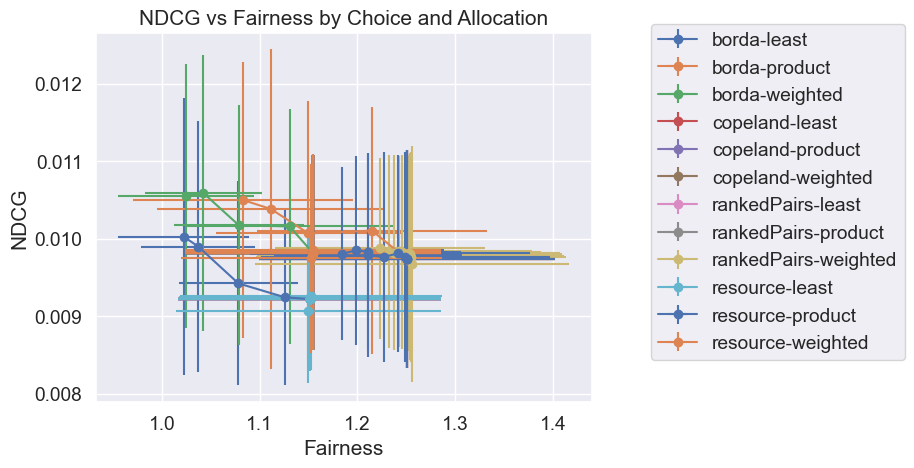

In [329]:
# Separate data for different choice-allocation combinations
for (choice, allocation), data in grouped_df.groupby(['choice', 'allocation']):
    plt.errorbar(data['fairness norm']['mean'], data['NDCG']['mean'],  yerr=data['NDCG']['std'],xerr=data['fairness norm']['std'], fmt='o-', 
                 label=f'{choice}-{allocation}')

# Adding labels and title
plt.xlabel('Fairness')
plt.ylabel('NDCG')
plt.title('NDCG vs Fairness by Choice and Allocation')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [300]:
# get fairness data to create boxplots
# create df w/ allocation/choice mechs and fairness scores over time
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["COUNTRY_low_pfr","loan_buck_5"],var_name='Agent', value_name="Fairness")

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# store baseline means, then remove baseline
baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "COUNTRY_low_pfr"]["Fairness"].mean()
baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "loan_buck_5"]["Fairness"].mean()
boxplots = experiments[experiments["Allocation Mech"] != "Baseline"]

In [ ]:
# rename for readability
boxplots.loc[boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
boxplots.loc[boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"
boxplots.replace("COUNTRY_low_pfr", "Country", inplace=True)
boxplots.replace("loan_buck_5", "Loan Size", inplace=True)

In [ ]:
# generate FacetGrid boxplots of internal representations of fairness scores 
sb.set(font_scale=1.5)

g = sb.catplot(data=boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["Country","Loan Size"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

In [ ]:
ndcg_fairness

In [ ]:
baseline_accuracy = ndcg_fairness.loc["Baseline"]
ndcg_fairness = ndcg_fairness.drop("Baseline")

In [ ]:
# rename for readability
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted')

In [ ]:
ndcg_fairness["Average Fairness Score"] = ndcg_fairness.apply(lambda x: (x["COUNTRY_low_pfr"]+x["loan_buck_5"])/2, axis=1)

In [187]:
def make_scatterplot(fairness_df, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='fairness',
                      y='NDCG',
                      data=fairness_df,
                      style="allocation",
                      hue="choice",
                      s=100,
                      markers={"product": "^", "weighted": "X", "least": "o"})

    sb.set(font_scale = 1.25)
    #plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [189]:
def difference_scatterplot(fairness_df, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='difference',
                      y='NDCG',
                      data=fairness_df,
                      style="allocation",
                      hue="choice",
                      s=100,
                      markers={"product": "^", "weighted": "X", "least": "o"})

    sb.set(font_scale = 1.25)
    #plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Difference of Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

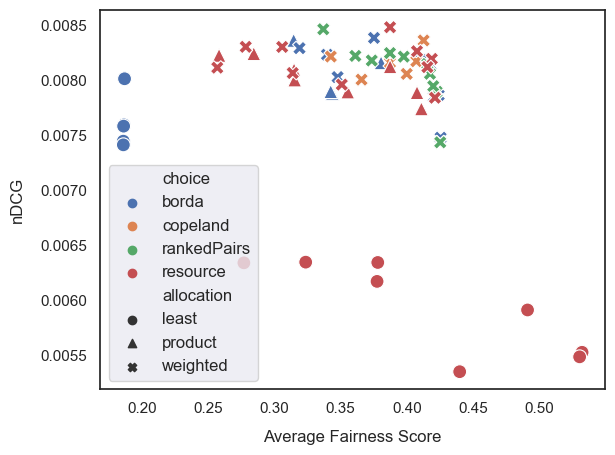

In [188]:
make_scatterplot(ndcg_fairness_k, filename='kiva_scatter.png')

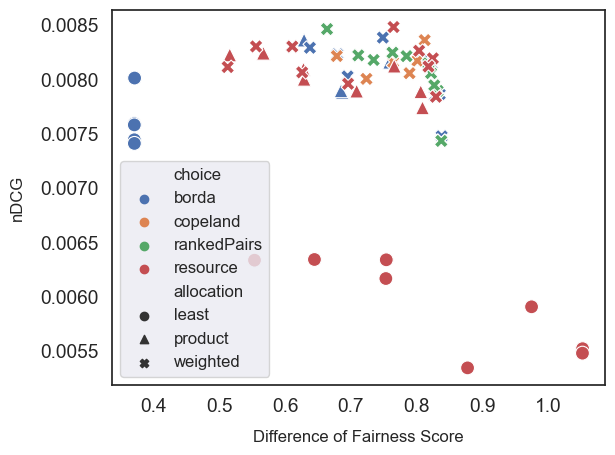

In [190]:
difference_scatterplot(ndcg_fairness_k, filename='difference_kiva_scatter.png')

In [ ]:
import os

Movies Experiments

In [ ]:
# Base paths and experiment numbers
base_path = "../data/"
experiments = range(1, 11)

# Specify the base names for each experiment
base_names = [
    #"history_file_borda_least_movie",
    "history_file_borda_product_movie",
    #"history_file_broda_weighted_movie",
    # Add other base names here
]

# Mapping of base names to lists and results dictionaries
#base_name_mapping = {
 #   "history_file_borda_weighted_movie": ('borda_w', 'results_borda_w'),
#}

# Generate file paths and mechanisms dynamically
history_files = []
mechanisms = []

for base_name in base_names:
    for experiment_number in experiments:
        history_file_path = os.path.join(base_path, f"{base_name}_{experiment_number}.json")
        mechanism_name = f"{base_name.split('_')[-1].capitalize()} Experiment {experiment_number}"
        history_files.append(history_file_path)
        mechanisms.append(mechanism_name)

recs_file = "../data/ratings.csv"
items_file = "../data/items.csv"

In [ ]:
borda_1= []
borda_2 = []
borda_3= []
borda_4 = []
borda_5= []
borda_6 = []
borda_7= []
borda_8 = []
borda_9= []
borda_10 = []


list_names = [borda_1, borda_2, borda_3, borda_4, borda_5, borda_6, borda_7, borda_8, borda_9, borda_10]
readable_names = ['Borda 1', 'Borda 2', 'Borda 3', 'Borda 4', 'Borda 5', ' Borda 6', 'Borda 7', 'Borda 8', 'Borda 9','Borda 10']

In [ ]:

results_borda_1= {}
results_borda_2 = {}
results_borda_3= {}
results_borda_4 = {}
results_borda_5= {}
results_borda_6 = {}
results_borda_7= {}
results_borda_8 = {}
results_borda_9= {}
results_borda_10 = {}



dict_names = [results_borda_1, results_borda_2,results_borda_3, results_borda_4, results_borda_5, results_borda_6, results_borda_7, results_borda_8, results_borda_9, results_borda_10]

In [ ]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicity determined. Defaulting to integer...")
        var = int(var)
    return var

# get recommendation score based on user and item ids
def lookupscore(user, item):
    score = recommender.loc[(recommender.User == typecast(recommender.User, user)) & (recommender.Item == typecast(recommender.Item, item))]
    if not score.empty:
        score = score['Score']
    else:
        score = 0.0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [ ]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'women_writer_director') | (item_features['Feature'] == 'non-en')]

In [ ]:
# read history files
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)

In [ ]:
# process history files into dictionaries for statistics
for list, dictionary in zip(list_names, dict_names):
    for line in list:
        results = line['choice_out']['results']
        results_list = []
        for item in results:
            results_list.append(item['item'])
        dictionary[line['user']] = results_list 

In [ ]:
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

In [ ]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for history, name in zip(processed_histories, mechanisms):
    users = []
    ndcg_values = []
    for user, items in processed_histories[history]["Statistics"].items():
        scores = []
        for item in items:
            scores.append(lookupscore(user, item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == typecast(recommender.User, user))]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [ ]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=readable_names, columns=["NDCG"])
ndcg_table

In [ ]:
# calculates proportional fairness for the representation of item features
num_features = 2
feature_names = ["women_writer_director","non-en"]
protected_features = ["women_writer_director","non-en"]
fairness_targets = [0.25, 0.25]

proportional_fairness = []
adj_fairness = []
feature_count= []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item)[0:1]):
                features[idx] = features[idx] + val
    
    feature_count.append(features[0])
    proportional = [(x)/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            if name in "non-en":
                print(proportional[idx])
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [ ]:
i = item_features[item_features['Feature']=='non-en']
i = i[i['BV'] == 1]
i

In [ ]:
prop_fairness = pd.DataFrame(adj_fairness)

In [ ]:
prop_fairness

In [ ]:
ndcg_table.reset_index(inplace=True)
ndcg_table = ndcg_table.rename(columns = {'index':'Type'})

In [ ]:
ndcg_fairness = prop_fairness.merge(ndcg_table, left_index = True, right_index = True)
ndcg_fairness = ndcg_fairness.rename(columns = {0:'Average Fairness Score'})

In [ ]:
ndcg_fairness

In [ ]:
# Extract the date and close price columns
Gender_fairness = ndcg_fairness['Average Fairness Score']
ndcg = ndcg_fairness['NDCG']

# Create a line plot
plt.plot(Gender_fairness, ndcg)

In [ ]:
dataset = item_features

# create a list of all feature combinations
all_features = ["women_writer_director", "non-en"]

# iterate over each item ID and feature combination
for item_id in range(1,1550):
    for feature in all_features:
        # check if the row exists
        row_exists = ((dataset["Item"] == item_id) & (dataset["Feature"] == feature)).any()

        # if the row doesn't exist, add a new row with item ID, feature, and value of 0
        if not row_exists:
            dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\

item_features = dataset

In [ ]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [ ]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

#light_recommender = Dict.empty(
 #   key_type=types.unicode_type,
  #  value_type=types.UniTuple(types.float64[:], 2),
#)
count=0
light_recommender = {}
for user in recommender["User"].unique():

    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    #print(type(light_recommender))
    count+=len(scores)
    light_recommender[user] = (scores, items)
print(count)

In [ ]:
import numpy as np
from numba import njit

def calculate_ndcg(histories, recommender, base_logs):
    avg_of_ndcg = []
    for history in histories:
        i_count = 0
        all_ndcg = 0
        for user, items in histories[history].items():
            scores_list = []
            for item in items:
                # Check if the user is in the recommender dictionary
                if user in recommender and len(recommender[user][1]) > 0:
                    idx_array = np.where(recommender[user][1] == item)[0]
                    if idx_array.size != 0:
                        idx = idx_array[0]
                        score = recommender[user][0][idx]
                    else:
                        score = 0.0
                else:
                    score = 0.0
                scores_list.append(score)

            scores = np.array(scores_list)  # Convert the list back to a NumPy array
            # Check if the user is in the recommender dictionary
            if user in recommender and len(recommender[user][0]) > 0:
                ideal_scores = np.sort(recommender[user][0])[::-1][:len(scores)]
                scores[scores > 0] = 1.0
                ideal_scores[ideal_scores > 0] = 1.0
                recdcg = np.sum(scores / base_logs)
                idealdcg = np.sum(ideal_scores / base_logs)
                if idealdcg == 0.0:
                    ndcg = 0
                else:
                    ndcg = recdcg / idealdcg
                i_count += 1
                all_ndcg += ndcg
        if i_count > 0:
            avg_of_ndcg.append(all_ndcg / i_count)
    return avg_of_ndcg


# Usage example:
# avg_ndcg = calculate_ndcg(histories_dict, recommender_dict, base_logs_array)



In [ ]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [ ]:
avg_of_ndcg

In [ ]:
from numba import typed
# Create a Numba-typed dictionary
num_keys = len(light_recommender)
numba_dict = typed.Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 559069),
    #size=num_keys
)
# Populate the Numba-typed dictionary with items from the regular dictionary
for key, value in light_recommender.items():
    numba_dict[key] = value

In [ ]:
type(numba_dict)

In [ ]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

In [ ]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["COUNTRY_low_pfr", "loan_buck_5"]
protected_features = ["COUNTRY_low_pfr", "loan_buck_5"]
fairness_targets = [0.20, 0.30]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [ ]:
#pip install numba==0.57.0